In [ ]:
import pandas as pd

# read data
df = pd.read_csv('path/to/spreadsheet.csv', low_memory=False)

In [5]:
# --- Plot configuration ---
features_config = [
    # {
    #     'feature': 'sleep_latency',
    #     'display': 'Sleep Latency (min)',
    #     'plot_type': 'violin',
    #     'bigger_than': False,
    #     'tuning': False,
    #     'ylim': (0, 60),
    #     'thr_stepsize': 1
    # },
    {
        'feature': 'rem_latency',
        'display': 'REM Latency (min)',
        'plot_type': 'violin',
        'bigger_than': False,
        'tuning': True,
        'ylim': (0., 120),
        'thr_stepsize': 1
    },
    # {
    #    'feature': 'soremC',
    #    'display': 'direct REM\n(Stephansen et al. 2018)',
    #    'plot_type': 'histogram',
    #    'bigger_than': True,
    #    'tuning': True,
    #    'ylim': (-0.5, 10.5)
    # },
    #{
    #    'feature': 'rem_in_first_30_min',
    #    'display': 'REM in first 30 min',
    #    'plot_type': 'violin',
    #    'bigger_than': True,
    #    'tuning': True,
    #    'ylim': (0, 60),
    #    'thr_stepsize': 1
    #},
    # TODO - consider normalized histogram (divide by total number of samples) - SEABORN likely has a 
    {
        'feature': 'soremp',
        'display': 'SOREMP\n(REML<15 min)',
        'plot_type': 'histogram',
        'bigger_than': True,
        'tuning': False,
        'ylim': (-0.5, 1.5),
        'thr_stepsize': 1
    },
    {
        'feature': 'five_n1w_to_two_r',
        'display': 'Direct REM\n(Christensen et al. 2015)',
        'plot_type': 'histogram',
        'bigger_than': True,
        'tuning': True,
        'ylim': (-0.5, 10.5),
        'thr_stepsize': 1
    }, 
    
]
# --- Source configuration ---
source_dicts = [
    {'source': 'sco', 'ls': '-', 'color': (0.1216, 0.4667, 0.7059), 'marker': 'o'}
    # {'source': 'pkl', 'ls': '--', 'color': (1.0000, 0.4980, 0.0549), 'marker': '*'}
]


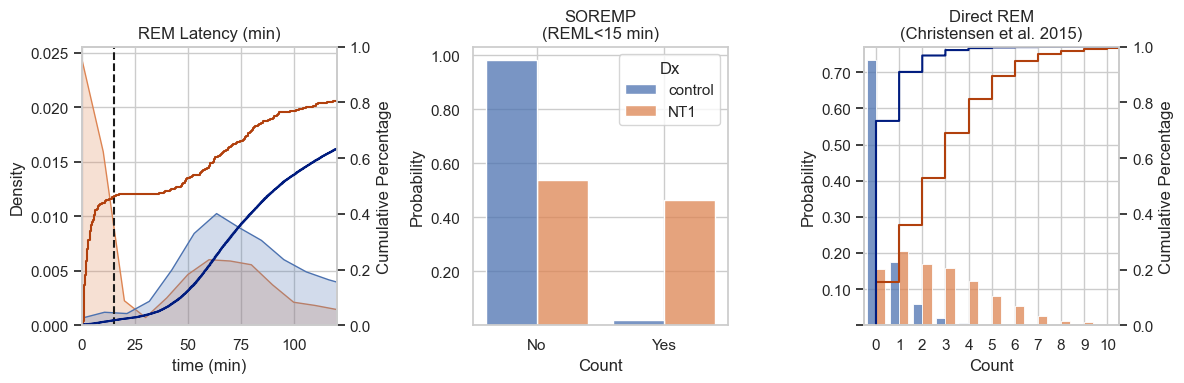

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# --- Global plotting style ---
sns.set(style='whitegrid')

for r, row in enumerate(source_dicts):

    fig, axes = plt.subplots(1, len(features_config), figsize=(12, 4))
    
    df_plot = df.copy()

    for c, conf in enumerate(features_config):
        ax = axes[c]

        # --- Plot main distribution ---
        if conf['plot_type'] == 'violin':
            sns.kdeplot(
                data=df_plot,
                x=conf['feature'],
                hue='Dx',
                hue_order=['control', 'NT1'],
                ax=ax,
                common_norm=False,
                fill=True,
                bw_adjust=0.1,
                clip=(0, np.inf)
            )
            ax.set_xlabel('time (min)')
            #ax.set_xscale('log', base=2)
            #ax.xaxis.set_major_formatter(
            #    FuncFormatter(lambda x, _: f'{int(x)}' if x >= 1 else '')
            #)
            #ax.xaxis.set_major_formatter(
            #    FuncFormatter(lambda x, _: f'{int(x)}' if x >= 1 else '')
            #)
            if conf['feature'] == 'rem_latency':
                ax.axvline(
                    x=15,
                    color='k', ls='--',
                    label='SOREMP threshold')
            

        elif conf['plot_type'] == 'count':
            sns.countplot(
                data=df_plot,
                x=conf['feature'],
                hue='Dx',
                hue_order=['control', 'NT1'],
                ax=ax
            )
            
            ax.set_xlabel('Count')
            ax.set_yscale('log')
            ax.yaxis.set_major_formatter(
                FuncFormatter(lambda x, _: f'{int(x)}' if x >= 1 else '')
            )

            if conf['feature'] != 'soremp':
                bins = np.arange(0, 11, 1)
                ax.set_xticks(bins)
                ax.set_xticklabels([str(tick) for tick in bins])
            if conf['feature'] == 'soremp':
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['No', 'Yes'])
            
        else:
            sns.histplot(
                data=df_plot,
                x=conf['feature'],
                hue='Dx',
                hue_order=['control', 'NT1'],
                ax=ax,
                stat='probability',  # normalize to sum to 1
                common_norm=False,   # don't normalize across all hue groups
                multiple='dodge',    # side-by-side bars like countplot
                shrink=0.8,          # optional: shrink bar width for spacing
                discrete=True        # ensure bars don't overlap if feature is discrete
            )

            # Set x-axis label
            ax.set_xlabel('Count')
            # ax.set_xlabel(conf['feature'])

            # Set xticks if feature isn't 'soremp'
            if conf['feature'] != 'soremp':
                bins = np.arange(0, 11, 1)
                ax.set_xticks(bins)
                ax.set_xticklabels([str(tick) for tick in bins])
            if conf['feature'] == 'soremp':
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['No', 'Yes'])

            # Remove log scaling
            #ax.set_yscale('log')
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}' if x > 0 else ''))

        # --- Overlay cumulative ECDF ---
        if conf['feature'] != 'soremp':
            ax2 = ax.twinx()
            sns.ecdfplot(
                data=df_plot,
                x=conf['feature'],
                hue='Dx',
                hue_order=['control', 'NT1'],
                ax=ax2,
                palette='dark'
            )
            ax2.set_ylabel('Cumulative Percentage')

            # Remove ECDF legend safely
            legend2 = ax2.get_legend()
            if legend2:
                legend2.remove()

        # --- Axis limits and title ---
        ax.set_xlim(conf['ylim'])
        ax.set_title(conf['display'])

        # Remove count/kde legend safely
        if c != 1:
            legend = ax.get_legend()
            if legend:
                legend.remove()
        
        ax2.grid(False)

    plt.tight_layout()